In [84]:
import pandas as pd
import os

In [85]:
df = pd.read_csv('pokemon.csv')

In [86]:
image_folder = 'images'

def get_image_path(pokemon_id):
    path = os.path.join(image_folder, f'{pokemon_id}.png')
    return path if os.path.exists(path) else None

In [87]:
df['image_path'] = df['Name'].apply(get_image_path)

In [88]:
# Check for missing images
missing = df[df['image_path'].isna()]
if not missing.empty:
    print(f"Warning: {len(missing)} images not found")
    print(missing['Name'].tolist())
    

In [8]:
print(df.head())

         Name  Type1   Type2   Evolution             image_path
0   bulbasaur  Grass  Poison     ivysaur   images\bulbasaur.png
1     ivysaur  Grass  Poison    venusaur     images\ivysaur.png
2    venusaur  Grass  Poison         NaN    images\venusaur.png
3  charmander   Fire     NaN  charmeleon  images\charmander.png
4  charmeleon   Fire     NaN   charizard  images\charmeleon.png


In [89]:
# Import libraries for image processing
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

Original image mode: RGBA
Original image size: (120, 120)
Original shape as array: (120, 120, 4)

Will resize to: (224, 224) for EfficientNet-B0


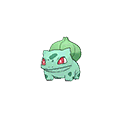

In [90]:
# Check a sample image - original size
sample_path = df['image_path'].iloc[0]
sample_img = Image.open(sample_path)
print(f"Original image mode: {sample_img.mode}")
print(f"Original image size: {sample_img.size}")
print(f"Original shape as array: {np.array(sample_img).shape}")
print(f"\nWill resize to: (224, 224) for EfficientNet-B0")
sample_img

In [91]:
def load_image_as_rgb(image_path, target_size=(224, 224)):
    """
    Load an image, convert RGBA to RGB, and resize for EfficientNet-B0.
    
    Args:
        image_path: Path to the image file
        target_size: Tuple of (width, height) - default 224x224 for EfficientNet-B0
        
    Returns:
        numpy array of shape (224, 224, 3) with RGB values
    """
    img = Image.open(image_path)
    
    # Convert RGBA to RGB if necessary
    if img.mode == 'RGBA':
        # Create a white background
        rgb_img = Image.new('RGB', img.size, (255, 255, 255))
        # Paste the RGBA image on white background using alpha channel as mask
        rgb_img.paste(img, mask=img.split()[3])  # 3 is the alpha channel
        img = rgb_img
    elif img.mode != 'RGB':
        # Convert any other mode to RGB
        img = img.convert('RGB')
    
    # Resize to target size for EfficientNet-B0 (224x224)
    img = img.resize(target_size, Image.Resampling.LANCZOS)
    
    # Convert to numpy array
    return np.array(img)

Resized RGB array shape: (224, 224, 3)
Data type: uint8
Value range: [0, 255]


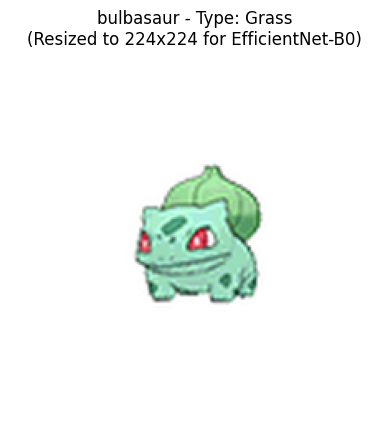

In [92]:
# Test the conversion and resizing on sample image
rgb_array = load_image_as_rgb(sample_path)
print(f"Resized RGB array shape: {rgb_array.shape}")  # Should be (224, 224, 3)
print(f"Data type: {rgb_array.dtype}")
print(f"Value range: [{rgb_array.min()}, {rgb_array.max()}]")

# Display the converted and resized image
plt.imshow(rgb_array)
plt.title(f"{df['Name'].iloc[0]} - Type: {df['Type1'].iloc[0]}\n(Resized to 224x224 for EfficientNet-B0)")
plt.axis('off')
plt.show()

In [93]:
# Load all images and convert to RGB arrays
print("Loading all images...")
image_arrays = []
valid_indices = []

for idx, row in df.iterrows():
    image_path = row['image_path']
    if pd.notna(image_path) and os.path.exists(image_path):
        try:
            rgb_array = load_image_as_rgb(image_path)
            image_arrays.append(rgb_array)
            valid_indices.append(idx)
        except Exception as e:
            print(f"Error loading {row['Name']}: {e}")
    
print(f"\nSuccessfully loaded {len(image_arrays)} images")

# Filter dataframe to only include successfully loaded images
df_valid = df.loc[valid_indices].reset_index(drop=True)

Loading all images...

Successfully loaded 809 images


In [94]:
# Verify all images are now standardized to (224, 224, 3)
shapes = [arr.shape for arr in image_arrays]
unique_shapes = set(shapes)

print(f"Number of unique image shapes: {len(unique_shapes)}")
print(f"All images shape: {shapes[0] if shapes else 'None'}")
print(f"Total images loaded: {len(image_arrays)}")

# Verify they're all (224, 224, 3)
all_correct_shape = all(shape == (224, 224, 3) for shape in shapes)
print(f"\n✅ All images are (224, 224, 3): {all_correct_shape}")

Number of unique image shapes: 1
All images shape: (224, 224, 3)
Total images loaded: 809

✅ All images are (224, 224, 3): True


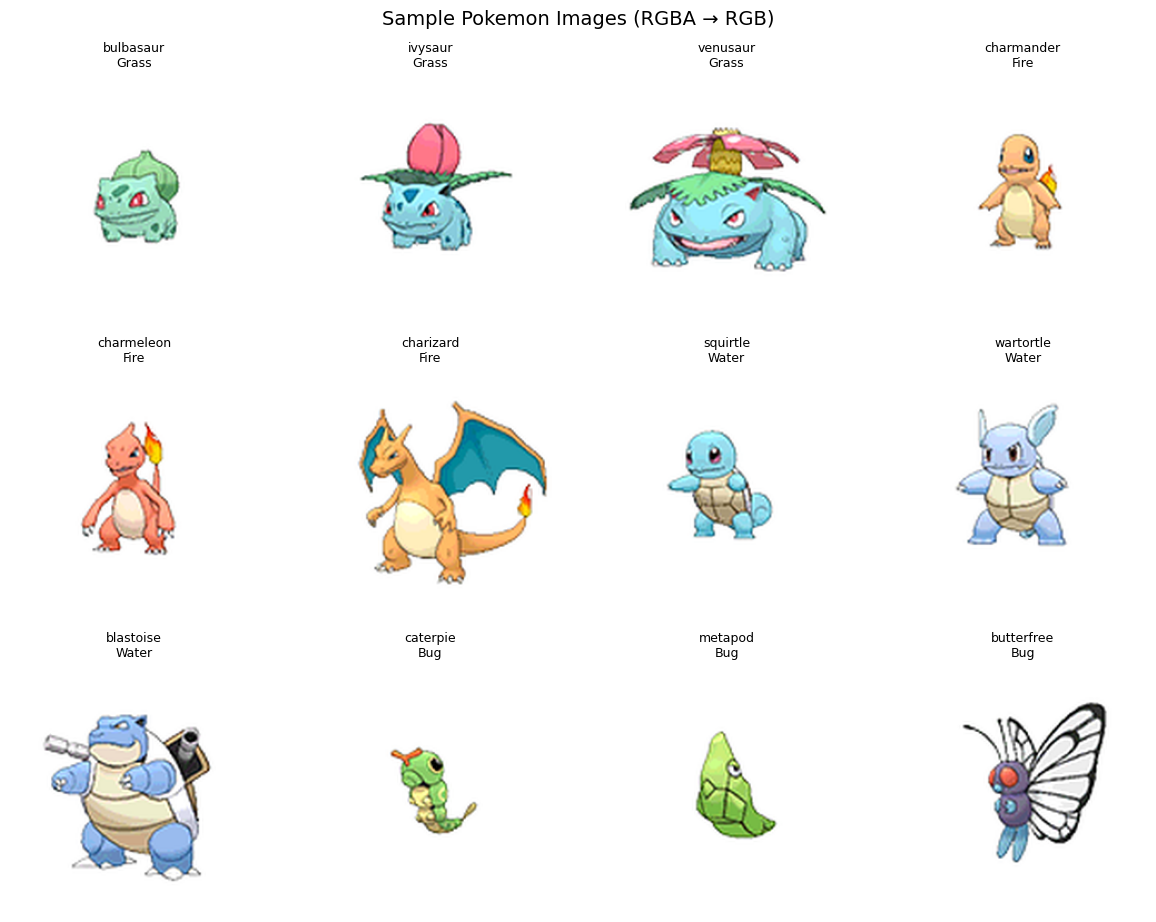

In [95]:
# Visualize a sample of converted images
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.ravel()

for i in range(12):
    if i < len(image_arrays):
        axes[i].imshow(image_arrays[i])
        axes[i].set_title(f"{df_valid['Name'].iloc[i]}\n{df_valid['Type1'].iloc[i]}", 
                         fontsize=9)
        axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Sample Pokemon Images (RGBA → RGB)', y=1.02, fontsize=14)
plt.show()

## Summary

✅ **Image Conversion & Preprocessing Complete**
- Loaded images from PNG files
- Converted RGBA → RGB (using white background for transparency)
- **Resized all images to 224×224 for EfficientNet-B0**
- Created standardized multidimensional numpy arrays (224 × 224 × 3)
- Verified all images loaded successfully with correct shape

**Why 224×224?**
- EfficientNet-B0 requires 224×224 input
- Used LANCZOS resampling for high-quality resizing
- All images now have consistent dimensions

**Next Steps:**
1. Normalize pixel values (divide by 255 or use ImageNet stats)
2. Create train/val/test splits (70/10/20)
3. Set up data augmentation pipeline
4. Export preprocessed data for training

Nearest Centroid Classifier

In [96]:
from collections import Counter

def is_near_white(pixel, threshold):
    return all(value >= 255 - threshold for value in pixel)


def find_most_frequent_color(img_array, threshold=10):
    """
    Find which color appears most frequently, excluding near-white colors (background).
    
    img_array: shape (224, 224, 3)
    threshold: how close to white (255) to exclude
    
    Returns: rgb tuple of most frequent non-white color
    """
    
    # Reshape to list of pixels: (224*224, 3)
    pixels = img_array.reshape(-1, 3)
    
    # Filter out near-white pixels
    non_white_pixels = [tuple(p) for p in pixels if not is_near_white(p, threshold)]
    
    # Count frequency of each unique color
    color_counts = Counter(non_white_pixels)
    
    # Get most frequent color
    if color_counts:
        most_frequent_color = color_counts.most_common(1)[0][0]
        return most_frequent_color
    else:
        return None  # All pixels were white

   
def find_average_color(img_array, threshold=10):
    """
    Find the average color, excluding near-white colors (background).
    
    img_array: shape (224, 224, 3)
    threshold: how close to white (255) to exclude
    
    Returns: rgb tuple of average non-white color
    """
    
    # Reshape to list of pixels: (224*224, 3)
    pixels = img_array.reshape(-1, 3)
    
    # Filter out near-white pixels
    non_white_pixels = np.array([p for p in pixels if not is_near_white(p, threshold)])
    
    # Calculate average
    if len(non_white_pixels) > 0:
        avg_color = non_white_pixels.mean(axis=0)
        # Convert to integers
        avg_color = tuple(int(c) for c in avg_color)
        return avg_color
    else:
        return None  # All pixels were white

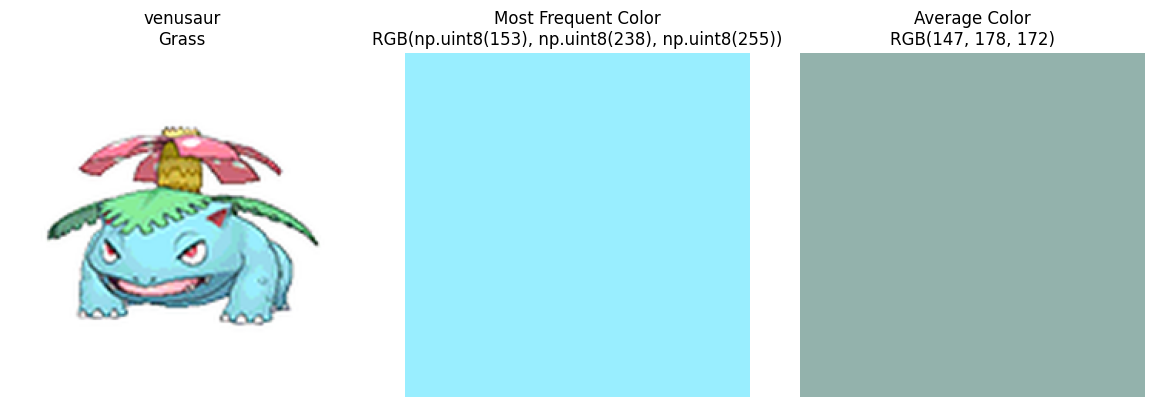

In [100]:
import matplotlib.pyplot as plt

# Display one image with most frequent and average color
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Show the original image
pokemon_index = 2  # Change index to view different images

axes[0].imshow(image_arrays[pokemon_index])
axes[0].set_title(f"{df_valid['Name'].iloc[pokemon_index]}\n{df_valid['Type1'].iloc[pokemon_index]}")
axes[0].axis('off')

# Show the most frequent color
most_frequent = find_most_frequent_color(image_arrays[pokemon_index])
color_array = np.array([[most_frequent]], dtype=np.uint8)
axes[1].imshow(color_array)
axes[1].set_title(f"Most Frequent Color\nRGB{most_frequent}")
axes[1].axis('off')

# Show the average color
avg_color = find_average_color(image_arrays[pokemon_index])
avg_color_array = np.array([[avg_color]], dtype=np.uint8)
axes[2].imshow(avg_color_array)
axes[2].set_title(f"Average Color\nRGB{avg_color}")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [101]:
def find_closest_color_category(rgb_color, color_categories):
    """
    Find which color category an RGB value is closest to.
    
    rgb_color: tuple like (123, 45, 67)
    color_categories: dict like {'red': [255, 0, 0], 'blue': [0, 0, 255], ...}
    
    Returns: category name (e.g., 'red')
    """
    # Convert numpy types to regular Python ints
    rgb_color = tuple(int(x) for x in rgb_color)
    
    min_distance = float('inf')
    closest_category = None
    
    for category, reference_color in color_categories.items():
        # Calculate Euclidean distance
        distance = np.sqrt(sum((rgb_color[i] - reference_color[i])**2 for i in range(3)))
        
        if distance < min_distance:
            min_distance = distance
            closest_category = category
    
    return closest_category

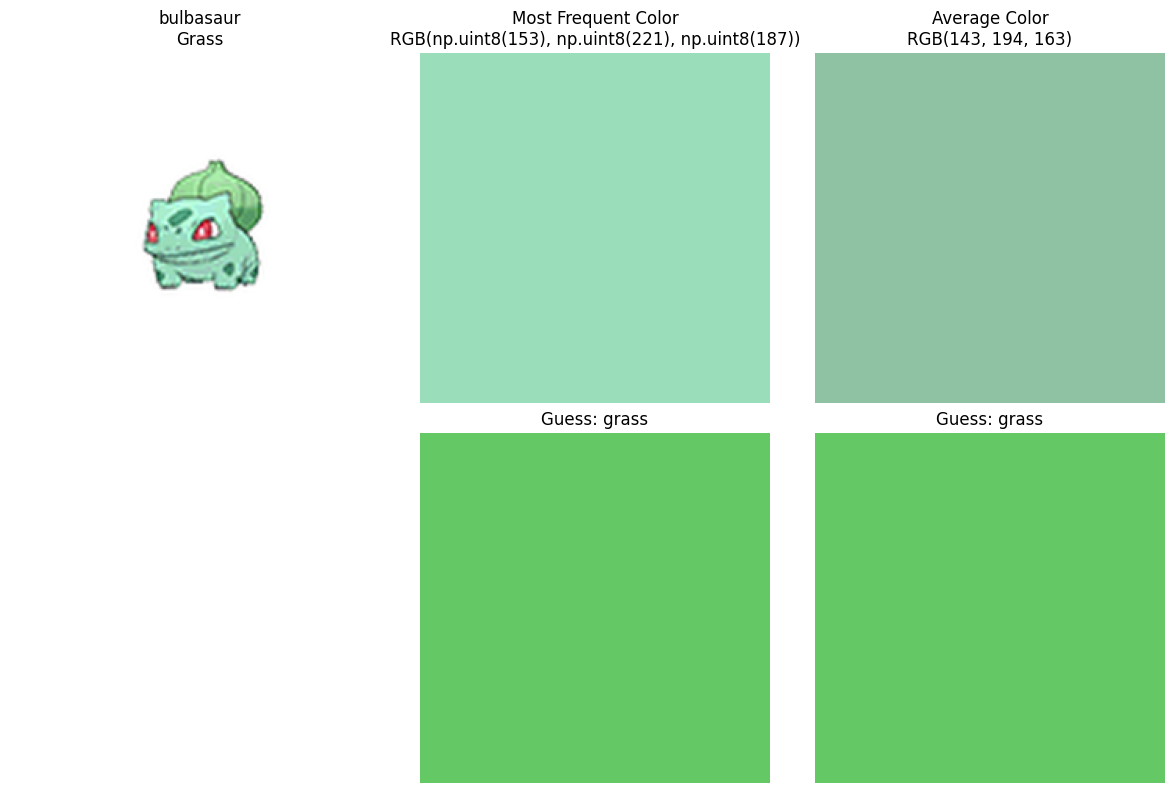

In [113]:
# Display one image with guesses from most frequent and average color
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Show the original image (spans both rows)
pokemon_index = 0  # Change index to view different images

axes[0, 0].imshow(image_arrays[pokemon_index])
axes[0, 0].set_title(f"{df_valid['Name'].iloc[pokemon_index]}\n{df_valid['Type1'].iloc[pokemon_index]}")
axes[0, 0].axis('off')
axes[1, 0].axis('off')  # Hide bottom left

# Color categories
color_categories = {
    'fire': [255, 100, 50],      # Orange-red
    'grass': [100, 200, 100],    # Medium green (closer to actual grass sprites)
    'water': [100, 150, 255],    # Light blue
    'electric': [255, 220, 0],   # Yellow
    'poison': [180, 100, 180],   # Purple (not pink!)
    'dark': [50, 50, 50]         # Dark gray (not pure black)
}

# Most frequent color
most_frequent = find_most_frequent_color(image_arrays[pokemon_index])
axes[0, 1].imshow(np.array([[most_frequent]], dtype=np.uint8))
axes[0, 1].set_title(f"Most Frequent Color\nRGB{most_frequent}")
axes[0, 1].axis('off')

closest_category_freq = find_closest_color_category(most_frequent, color_categories)
axes[1, 1].imshow(np.array([[color_categories[closest_category_freq]]], dtype=np.uint8))
axes[1, 1].set_title(f"Guess: {closest_category_freq}")
axes[1, 1].axis('off')

# Average color
avg_color = find_average_color(image_arrays[pokemon_index])
axes[0, 2].imshow(np.array([[avg_color]], dtype=np.uint8))
axes[0, 2].set_title(f"Average Color\nRGB{avg_color}")
axes[0, 2].axis('off')

closest_category_avg = find_closest_color_category(avg_color, color_categories)
axes[1, 2].imshow(np.array([[color_categories[closest_category_avg]]], dtype=np.uint8))
axes[1, 2].set_title(f"Guess: {closest_category_avg}")
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

EDA

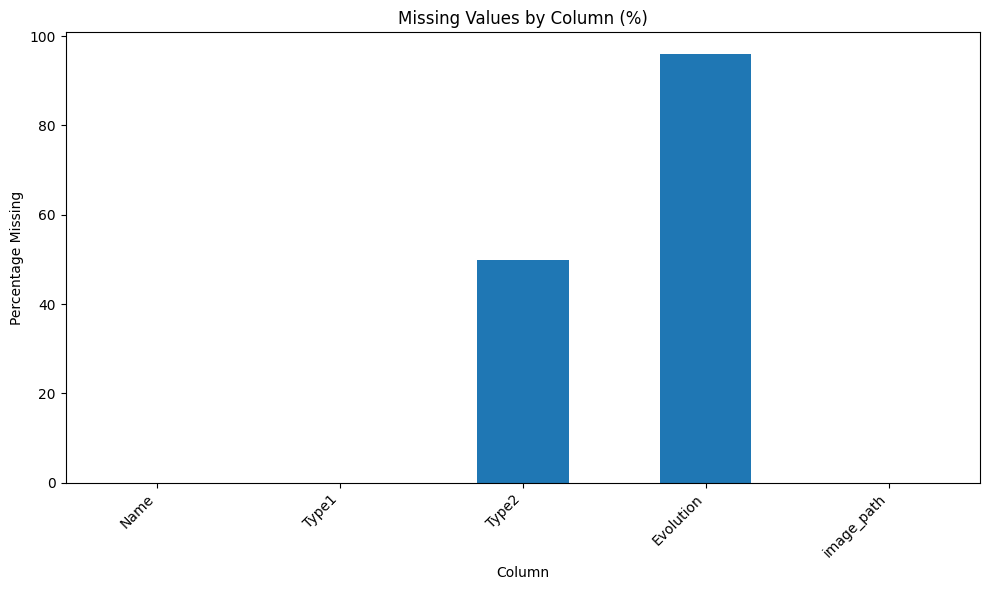

In [79]:
missing_pct = (df.isnull().sum() / len(df)) * 100

plt.figure(figsize=(10, 6))
missing_pct.plot(kind='bar')
plt.title('Missing Values by Column (%)')
plt.xlabel('Column')
plt.ylabel('Percentage Missing')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

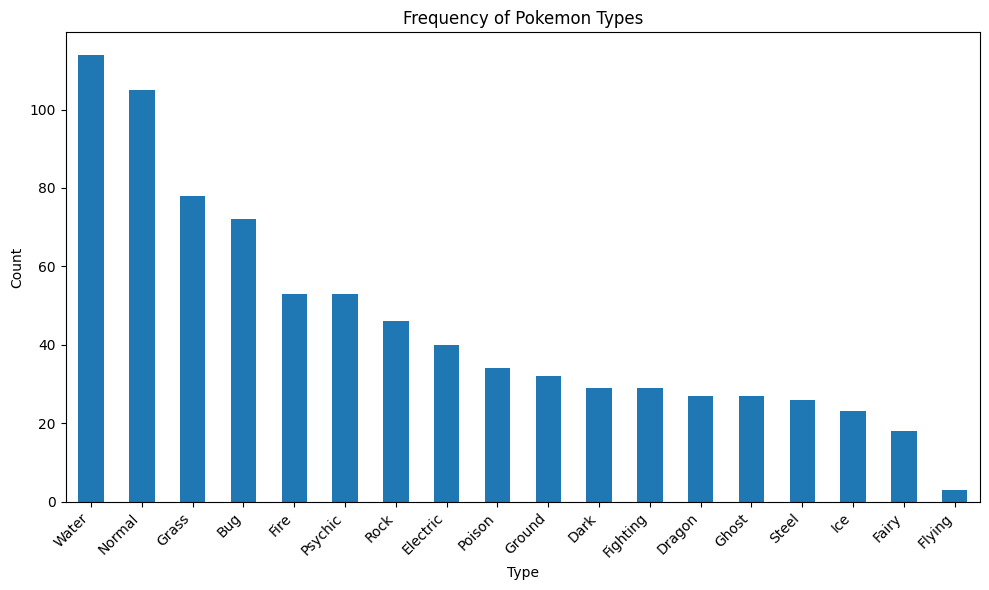

Type1
Water       114
Normal      105
Grass        78
Bug          72
Fire         53
Psychic      53
Rock         46
Electric     40
Poison       34
Ground       32
Dark         29
Fighting     29
Dragon       27
Ghost        27
Steel        26
Ice          23
Fairy        18
Flying        3
Name: count, dtype: int64


In [81]:
# Count frequency of each type
type_counts = df['Type1'].value_counts()

# Create bar chart
plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar')
plt.title('Frequency of Pokemon Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Optional: print the counts
print(type_counts)

Evaluation of Nearest Centroid Classifier

In [115]:
def predict(img_array, color_categories, centroid_calculation_method='most_frequent'):
    """
    Predict the Pokemon type based on the centroid calculation method in the image.
    
    img_array: numpy array of shape (224, 224, 3)
    color_categories: dict of category name to RGB reference color

    Returns: predicted category name
    """
    if centroid_calculation_method == 'most_frequent':
        most_frequent = find_most_frequent_color(img_array)
        if most_frequent is not None:
            return find_closest_color_category(most_frequent, color_categories)
    elif centroid_calculation_method == 'average':
        avg_color = find_average_color(img_array)
        if avg_color is not None:
            return find_closest_color_category(avg_color, color_categories)

    return None  # Could not determine a color (e.g., all white)


types = {
    'water': [100, 150, 255],    # Light blue
    'normal': [168, 168, 120],   # Beige/tan
    'grass': [100, 200, 100],    # Medium green
    'bug': [168, 184, 32],       # Yellow-green
    'fire': [255, 120, 80],      # Orange-red
    'psychic': [255, 100, 180],  # Pink
    'rock': [184, 160, 88],      # Brown/tan
    'electric': [255, 220, 0],   # Yellow
    'poison': [160, 64, 160],    # Purple
    'ground': [224, 192, 104],   # Sandy brown
    'dark': [80, 65, 63],        # Dark brown/gray
    'fighting': [192, 48, 40],   # Dark red
    'dragon': [112, 56, 248],    # Purple-blue
    'ghost': [112, 88, 152],     # Dark purple
    'steel': [184, 184, 208],    # Gray
    'ice': [152, 216, 216],      # Light cyan
    'fairy': [238, 153, 172],    # Light pink
    'flying': [168, 144, 240]    # Light purple
}

In [118]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

In [124]:
# Make predictions for all images
predictions = []
actual_types = []

for i in range(len(image_arrays)):
    # Get prediction
    most_frequent = find_average_color(image_arrays[i])
    predicted_type = find_closest_color_category(most_frequent, types)
    predictions.append(predicted_type)
    
    # Get actual type
    actual_types.append(df_valid['Type1'].iloc[i].lower())

Accuracy: 11.62%
Macro F1 Score: 7.80%

Classification Report:
              precision    recall  f1-score   support

         bug       0.50      0.01      0.03        72
        dark       0.24      0.21      0.22        29
      dragon       0.00      0.00      0.00        27
    electric       0.00      0.00      0.00        40
       fairy       0.12      0.17      0.14        18
    fighting       0.00      0.00      0.00        29
        fire       0.50      0.02      0.04        53
      flying       0.00      0.00      0.00         3
       ghost       0.09      0.37      0.14        27
       grass       0.83      0.06      0.12        78
      ground       0.05      0.06      0.05        32
         ice       0.23      0.30      0.26        23
      normal       0.17      0.48      0.25       105
      poison       0.25      0.03      0.05        34
     psychic       0.00      0.00      0.00        53
        rock       0.03      0.04      0.03        46
       steel      

c:\Users\bella\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\bella\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\bella\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

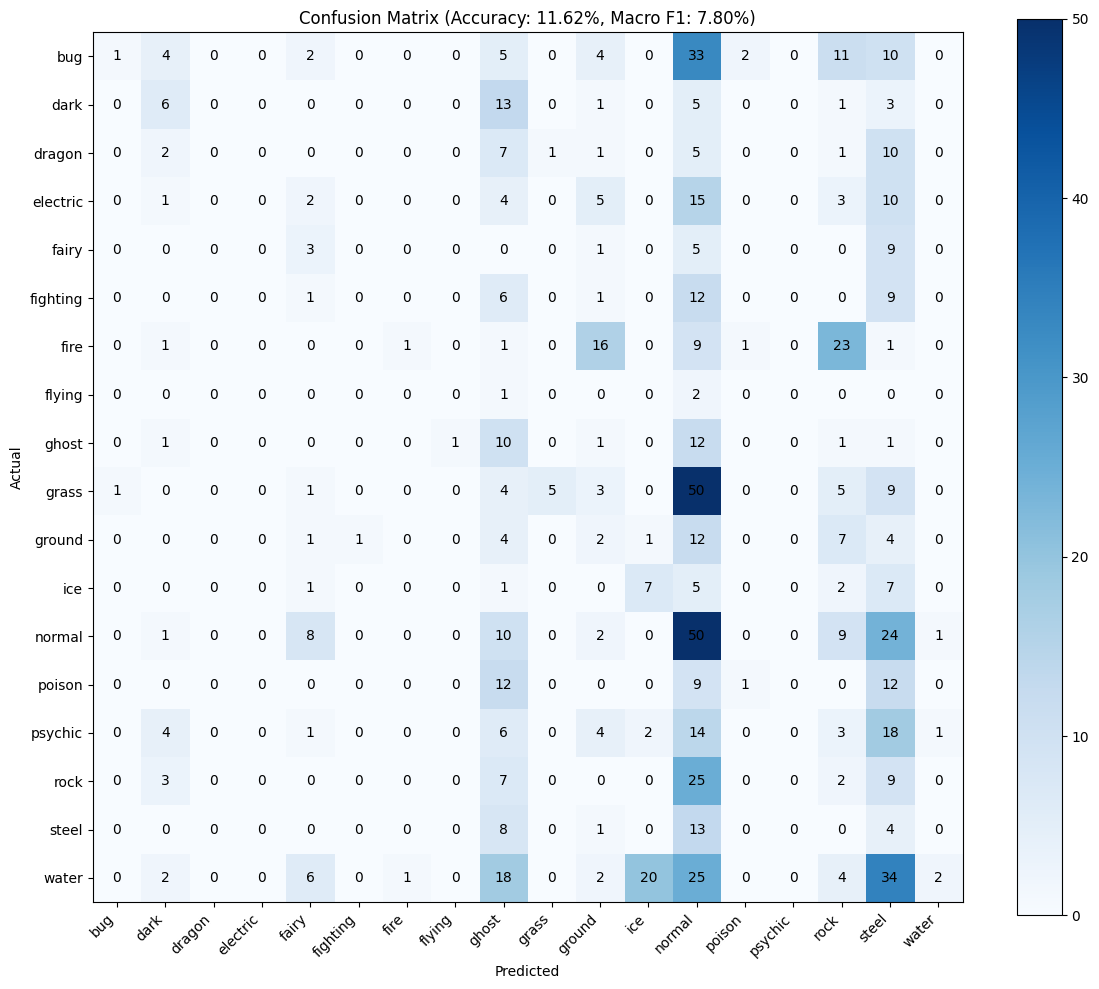

In [125]:
# Calculate accuracy
accuracy = accuracy_score(actual_types, predictions)
macro_f1 = f1_score(actual_types, predictions, average='macro')

print(f"Accuracy: {accuracy:.2%}")
print(f"Macro F1 Score: {macro_f1:.2%}")

# Detailed report
print("\nClassification Report:")
report = classification_report(actual_types, predictions, output_dict=True)
print(classification_report(actual_types, predictions))

# Extract F1 scores by class
print("\nF1 Score by Class:")
for class_name in sorted(set(actual_types)):
    if class_name in report:
        f1 = report[class_name]['f1-score']
        print(f"{class_name}: {f1:.2%}")

# Confusion matrix
cm = confusion_matrix(actual_types, predictions)
labels = sorted(set(actual_types))

plt.figure(figsize=(12, 10))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.yticks(range(len(labels)), labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2%}, Macro F1: {macro_f1:.2%})')

# Add text annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')

plt.tight_layout()
plt.show()